# **Writing Score model**

## Objectives

- Train and evaluate a model for predicting a student's writing score

## Inputs

- outputs/datasets/filtered/writing-score-dataset.csv
- outputs/datasets/split/writing/writing-test-score.csv
- outputs/datasets/split/writing/writing-train-score.csv
- outputs/datasets/split/writing/writing-test-vars.csv
- outputs/datasets/split/writing/writing-train-vars.csv

## Outputs

- A pipeline to predict a student's reading score

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [1]:
import os
current_directory = os.getcwd()
current_directory


'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [2]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [3]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

Import packages:

In [4]:
### Standard Data Science modules:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

### SciKit Learn modules
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

### EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualFrequencyDiscretiser, ArbitraryDiscretiser

### packages for classification report and confusion matrix
from sklearn.metrics import make_scorer, recall_score

### Train test split
from sklearn.model_selection import train_test_split

### Packages for generating a classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Writing Score Pipeline

The dataset's writing_score variable is a continuous numerical variable, like the math_score and reading_score variables. Given this, as we noted in the reading_score pipeline notebook, we would normally expect to fit a regression model. However, as we saw in those previous notebooks, regression models perform poorly. Therefore, as with the reading_score pipeline notebook, we shall convert to a classification task from the start, as classification algorithms fitted on binned datasets have showed good (but not spectacular) performance.

First, we must load the appropriate dataset:

In [5]:
df_writing = pd.read_csv('outputs/datasets/filtered/writing-score-dataset.csv')
df_writing

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,writing_score
0,male,group A,high school,standard,completed,63
1,female,group D,some high school,free/reduced,none,55
2,male,group E,some college,free/reduced,none,50
3,male,group B,high school,standard,none,68
4,male,group E,associate's degree,standard,completed,68
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,65
996,male,group D,associate's degree,free/reduced,completed,92
997,female,group C,some high school,free/reduced,none,41
998,female,group C,some college,standard,none,82


Now we must define the various objects that we will use to perform the analyses. First, the familiar HyperparameterOptimisationSearch class:

In [6]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches

Now the pipeline. Most pipelines use a StandardScaler step, however we don't need one here, because all of our feature variables are encoded categorical variables, and a StandardScaler only has use when we have continuous numerical variables.

In [7]:
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['gender', 'ethnicity', 'parental_education', 'lunch_program', 'test_preparation_course'] ) ),      

      ("feature_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

And now the algorithms and default hyperparameters that we will use. We will use different dictionaries in each section to hold the selected model and hyperparameters that we want to test, depending on what algorithm performs best. The SGDClassifier algorithm was used, but is currently commented out due to the difficulties encountered.

In [8]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    # "SGDClassifier": SGDClassifier(random_state=0),
}

parameters_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
    # "SGDClassifier": {}
}

And now finally the code for the classification report and confusion matrix:

In [9]:
def confusion_matrix_and_report(x, y, pipeline, label_map):

  prediction = pipeline.predict(x)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction, target_names=label_map),"\n")



def clf_performance(writing_train_vars, writing_train_score, writing_test_vars, writing_test_score, pipeline, label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(writing_train_vars, writing_train_score, pipeline, label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(writing_test_vars, writing_test_score, pipeline, label_map)

## 2 Bin approach

We can now sort the writing_score variable into bins for the 2 bin approach. As with the previous 2 classification tasks, we will consider 2, 3 and 4 bin approaches, with a view that 2 bins will probably be the superior approach, given previous results. We could proceed solely with the 2 bin approach, as we have used that for the other classification tasks, but we must approach the writing_score classification task independently, and it may turn out that one of the other approaches is superior.

* The classes represent the following ranges: 
{'writing_score': [-inf, 68.0, inf]} 



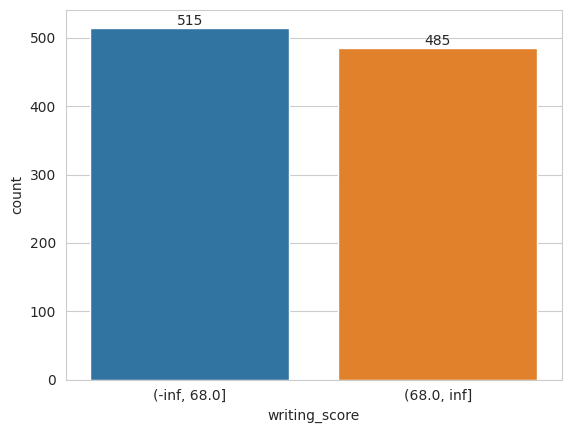

In [49]:
disc_efd_2 = EqualFrequencyDiscretiser(q=2, variables=['writing_score'])
df_writing_clf_efd_2 = disc_efd_2.fit_transform(df_writing)

print(f"* The classes represent the following ranges: \n{disc_efd_2.binner_dict_} \n")
fig_writing_clf_efd_2 = sns.countplot(data=df_writing_clf_efd_2, x='writing_score')
plt.bar_label(fig_writing_clf_efd_2.containers[0])
plt.show()

The EqualFrequencyDiscretiser has set the break-point as 68, meaning that students who score 68 and below are sorted into the lower class, and students who score 69 and above are sorted into the upper class. From the Pandas Profile Report in notebook 02-data-analysis-2, we note that the mean value of the writing_score column is 67.7. This means that students who score 68 - the actual mean score since scores are whole numbers - are sorted into the lower class. We saw this phenomenon in the reading_score notebook as well. As there, we will pursue an approach that uses the ArbitraryDiscretiser later on. For the moment, we will continue with the EqualFrequencyDiscretiserApproach.

In [11]:
df_writing_clf_efd_2

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,writing_score
0,male,group A,high school,standard,completed,0
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,0
4,male,group E,associate's degree,standard,completed,0
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,0
996,male,group D,associate's degree,free/reduced,completed,1
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,1


Now we must split the dataset into train and test sets:

In [12]:
writing_train_vars_2, writing_test_vars_2, writing_train_score_2, writing_test_score_2 = train_test_split(
    df_writing_clf_efd_2.drop(['writing_score'], axis=1),
    df_writing_clf_efd_2['writing_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", writing_train_vars_2.shape, writing_train_score_2.shape, "\n* Test set:",  writing_test_vars_2.shape, writing_test_score_2.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


In [13]:
model_search_2 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_2.fit(writing_train_vars_2, writing_train_score_2, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Inde


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Now we can examine the results:

In [14]:
efd_2_model_grid_search_summary, efd_2_model_grid_search_pipelines = model_search_2.score_summary(sort_by='mean_score')
efd_2_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
3,GradientBoostingClassifier,0.756098,0.817073,0.890244,0.04563
0,XGBClassifier,0.682927,0.795122,0.914634,0.091064
1,DecisionTreeClassifier,0.54878,0.653659,0.743902,0.07136
4,ExtraTreesClassifier,0.54878,0.653659,0.743902,0.07136
2,RandomForestClassifier,0.54878,0.631707,0.695122,0.049627
5,AdaBoostClassifier,0.54878,0.612195,0.670732,0.041821


Interesting - the GradientBoostingClassifier performs best, edging out the XGBClassifier, which we used in the reading_score pipeline.

In [15]:
models_2 = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0)
}
 
parameters_2 = {
     "GradientBoostingClassifier":{
                                'model__n_estimators': [100, 50, 140],
                                'model__learning_rate':[0.1, 0.01, 0.001],
                                'model__max_depth': [3, 15, None],
                                'model__min_samples_split': [2, 50],
                                'model__min_samples_leaf': [1, 50],
                                'model__max_leaf_nodes': [None, 50],
                            }

}

And now we call the hyperparameter optimisation class:

In [16]:
parameters_search_2 = HyperparameterOptimizationSearch(models=models_2, parameters=parameters_2)
parameters_search_2.fit(writing_train_vars_2, writing_train_score_2, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [17]:
efd_2_parameters_grid_search_summary, efd_2_parameters_grid_search_pipelines = parameters_search_2.score_summary(sort_by='mean_score')
efd_2_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
190,GradientBoostingClassifier,0.890244,0.939024,0.97561,0.03362,0.001,15,50,50,50,50
145,GradientBoostingClassifier,0.890244,0.939024,0.97561,0.03362,0.001,3,None,1,2,50
175,GradientBoostingClassifier,0.890244,0.939024,0.97561,0.03362,0.001,15,None,50,2,50
199,GradientBoostingClassifier,0.890244,0.939024,0.97561,0.03362,0.001,None,None,50,2,50
154,GradientBoostingClassifier,0.890244,0.939024,0.97561,0.03362,0.001,3,None,50,50,50


Very interesting - it appears that we have been able to considerably improve performance of the GradientBoostingClassifier.

In [18]:
writing_efd_2_best_model = efd_2_parameters_grid_search_summary.iloc[0,0]
writing_efd_2_best_model

'GradientBoostingClassifier'

In [19]:
writing_efd_2_best_parameters = efd_2_parameters_grid_search_pipelines[writing_efd_2_best_model].best_params_
writing_efd_2_best_parameters

{'model__learning_rate': 0.001,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

In [20]:
efd_2_pipeline_clf = efd_2_parameters_grid_search_pipelines[writing_efd_2_best_model].best_estimator_
efd_2_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estimators=50, random_state=0))])

We can now assess feature importance:

* These are the 3 most important features in descending order. The model was trained on them: 
['parental_education', 'lunch_program', 'test_preparation_course']


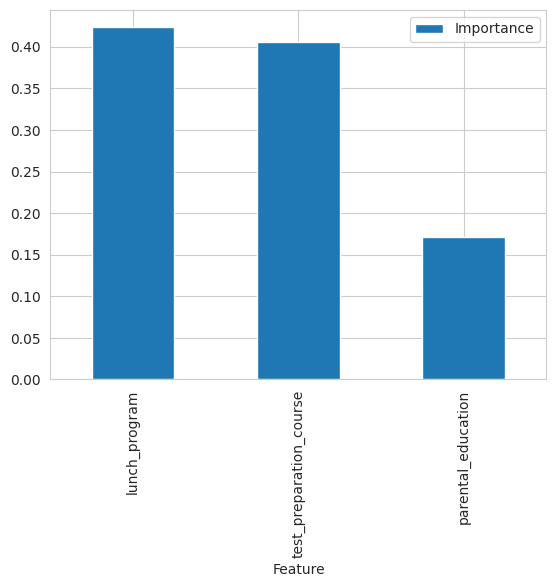

In [21]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(efd_2_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_2)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_2 = columns_after_data_cleaning_feat_eng[efd_2_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_2 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[efd_2_pipeline_clf['feature_selection'].get_support()],
          'Importance': efd_2_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

writing_efd_2_best_features = df_feature_importance_2['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_2)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_2}")

df_feature_importance_2.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - the lunch_program, test_preparation_course and parental_education variables have been identified as being the most important. This lines up with the influences and relationships identified in our data analysis notebooks. We can now proceed to generate a classification report and confusion matrix:

In [22]:
disc_efd_2.binner_dict_['writing_score']

[-inf, 68.0, inf]

In [23]:
writing_efd_2_label_map = ['<68.0', '>68.0'] # can rename to 'average or below' and 'better than average'
writing_efd_2_label_map

['<68.0', '>68.0']

In [24]:
clf_performance(writing_train_vars_2, writing_train_score_2, writing_test_vars_2, writing_test_score_2, efd_2_pipeline_clf, writing_efd_2_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                 Actual <68.0 Actual >68.0
Prediction <68.0          403          333
Prediction >68.0            7           57


---  Classification Report  ---
              precision    recall  f1-score   support

       <68.0       0.55      0.98      0.70       410
       >68.0       0.89      0.15      0.25       390

    accuracy                           0.57       800
   macro avg       0.72      0.56      0.48       800
weighted avg       0.71      0.57      0.48       800
 

#### Test Set ####

---  Confusion Matrix  ---
                 Actual <68.0 Actual >68.0
Prediction <68.0          101           83
Prediction >68.0            4           12


---  Classification Report  ---
              precision    recall  f1-score   support

       <68.0       0.55      0.96      0.70       105
       >68.0       0.75      0.13      0.22        95

    accuracy                           0.56       200
   macro avg       0.65      0.

Very interesting - for the lowest-performing class, we have recall scores of 0.98 for the train set and 0.96 for the test set. This is amazing, indicative of near-perfect predictive performance. As with the reading_score pipeline, performance for the higher performing classs is very poor, though since the business requirements are to predict students who will likely fall into this lower-performing class, this is immaterial.

As noted above, the EqualFrequencyDiscretiser set the break-point between the classes at 68, which includes students who achieve the mean score. As with the reading_score model notebook, we will explore use of the ArbitraryDiscretiser.

## 2 Bin approach Alternate

When using the ArbitraryDiscretiser here, we will use a break-point between the classes of 67, so that students who score 67 and below are in the lower class. Students who score 68 and above are in the upper class. When we used the ArbitraryDiscretiser in the 

* The classes represent the following ranges: 
{'writing_score': [-inf, 67, inf]} 



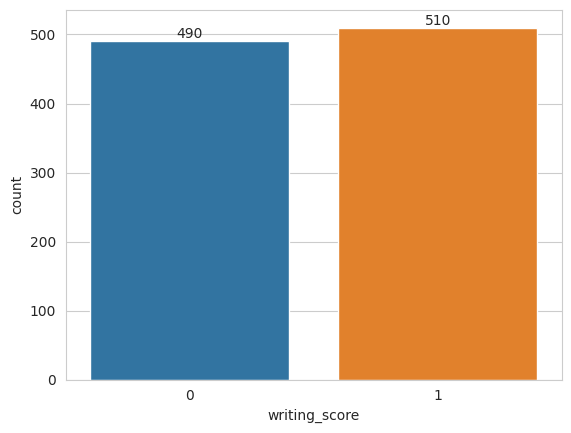

In [31]:
disc_ad_2 = ArbitraryDiscretiser(binning_dict={'writing_score':[-np.inf, 67, np.inf]})

df_writing_clf_ad_2 = disc_ad_2.fit_transform(df_writing)

print(f"* The classes represent the following ranges: \n{disc_ad_2.binner_dict_} \n")
fig_writing_clf_ad_2 = sns.countplot(data=df_writing_clf_ad_2, x='writing_score')
plt.bar_label(fig_writing_clf_ad_2.containers[0])
plt.show()

In [32]:
df_writing_clf_ad_2

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,writing_score
0,male,group A,high school,standard,completed,0
1,female,group D,some high school,free/reduced,none,0
2,male,group E,some college,free/reduced,none,0
3,male,group B,high school,standard,none,1
4,male,group E,associate's degree,standard,completed,1
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,0
996,male,group D,associate's degree,free/reduced,completed,1
997,female,group C,some high school,free/reduced,none,0
998,female,group C,some college,standard,none,1


The distribution has shifted 25 records into the upper class.

We can now split the dataset into train and test sets:

In [33]:
writing_train_vars_2_ad, writing_test_vars_2_ad, writing_train_score_2_ad, writing_test_score_2_ad = train_test_split(
    df_writing_clf_ad_2.drop(['writing_score'], axis=1),
    df_writing_clf_ad_2['writing_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", writing_train_vars_2_ad.shape, writing_train_score_2_ad.shape, "\n* Test set:",  writing_test_vars_2_ad.shape, writing_test_score_2_ad.shape)

* Train set: (800, 5) (800,) 
* Test set: (200, 5) (200,)


Now we can conduct our algorithm quick search. We will reuse the dictionaries defined above.

In [34]:
model_search_2 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_2.fit(writing_train_vars_2_ad, writing_train_score_2_ad, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


We can now examine the results:

In [35]:
ad_2_model_grid_search_summary, ad_2_model_grid_search_pipelines = model_search_2.score_summary(sort_by='mean_score')
ad_2_model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
0,XGBClassifier,0.320513,0.75308,0.935065,0.224299
3,GradientBoostingClassifier,0.602564,0.696237,0.766234,0.068809
1,DecisionTreeClassifier,0.532468,0.574592,0.615385,0.028051
4,ExtraTreesClassifier,0.532468,0.574592,0.615385,0.028051
2,RandomForestClassifier,0.454545,0.546121,0.615385,0.053564
5,AdaBoostClassifier,0.461538,0.520546,0.589744,0.045465


We see above that the XGBClassifier performs well, but that it also has a very wide range - from 0.32 to 0.93. The mean_score is excellent, if slightly inferior to the EqualFrequencyDiscretiser approach, which had a mean_score of 0.81. Now we will optimise the hyperparameters:

In [36]:
models_2_ad = {
    "XGBClassifier": XGBClassifier(random_state=0)
}
 
parameters_2_ad = {
    "XGBClassifier":{
                    'model__n_estimators': [30, 80, 200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01, 0.1, 0.001],
                    'model__gamma': [0, 0.1],
                    }
}

In [37]:
parameters_search_2_ad = HyperparameterOptimizationSearch(models=models_2_ad, parameters=parameters_2_ad)
parameters_search_2_ad.fit(writing_train_vars_2_ad, writing_train_score_2_ad, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Ind

In [39]:
ad_2_parameters_grid_search_summary, ad_2_parameters_grid_search_pipelines = parameters_search_2_ad.score_summary(sort_by='mean_score')
ad_2_parameters_grid_search_summary.head()

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__gamma,model__learning_rate,model__max_depth,model__n_estimators
0,XGBClassifier,0.461538,0.781285,0.935065,0.170561,0,0.01,None,30
23,XGBClassifier,0.461538,0.781285,0.935065,0.170561,0,0.001,3,200
25,XGBClassifier,0.461538,0.781285,0.935065,0.170561,0,0.001,15,80
26,XGBClassifier,0.461538,0.781285,0.935065,0.170561,0,0.001,15,200
1,XGBClassifier,0.461538,0.781285,0.935065,0.170561,0,0.01,None,80


It seems that we have been able to boost performance slightly, from 0.75 to 0.78

In [40]:
writing_ad_2_best_model = ad_2_parameters_grid_search_summary.iloc[0,0]
writing_ad_2_best_model

'XGBClassifier'

In [41]:
writing_ad_2_best_parameters = ad_2_parameters_grid_search_pipelines[writing_ad_2_best_model].best_params_
writing_ad_2_best_parameters

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': None,
 'model__n_estimators': 30}

In [42]:
ad_2_pipeline_clf = ad_2_parameters_grid_search_pipelines[writing_ad_2_best_model].best_estimator_
ad_2_pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         gamma=N...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
           

Now we can assess feature importance:

* These are the 2 most important features in descending order. The model was trained on them: 
['lunch_program', 'test_preparation_course']


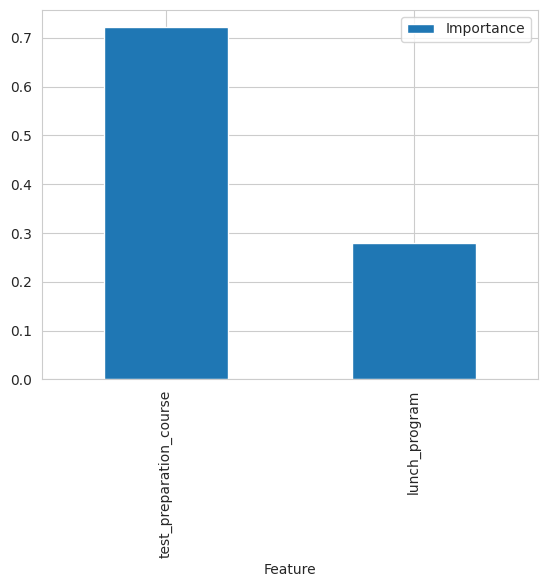

In [43]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(ad_2_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_2_ad)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_2_ad = columns_after_data_cleaning_feat_eng[ad_2_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_2_ad = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[ad_2_pipeline_clf['feature_selection'].get_support()],
          'Importance': ad_2_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

writing_ad_2_best_features = df_feature_importance_2_ad['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_2_ad)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_2_ad}")

df_feature_importance_2_ad.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - it appears that the test_preparation_course and lunch_program variables are the most important here. Previously, we also had the parental_education variable as well. Oddly, the test_preparation_course is the most important, which clashes with our previous analyses that indicate that lunch_program has considerable influence on student performance.

We can now construct a classification report and confusion matrix:

In [44]:
disc_ad_2.binner_dict_['writing_score']

[-inf, 67, inf]

In [45]:
writing_ad_2_label_map = ['Below average', 'Average or above']
writing_ad_2_label_map

['Below average', 'Average or above']

In [46]:
clf_performance(writing_train_vars_2_ad, writing_train_score_2_ad, writing_test_vars_2_ad, writing_test_score_2_ad, ad_2_pipeline_clf, writing_ad_2_label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                            Actual Below average Actual Average or above
Prediction Below average                     352                     264
Prediction Average or above                   36                     148


---  Classification Report  ---
                  precision    recall  f1-score   support

   Below average       0.57      0.91      0.70       388
Average or above       0.80      0.36      0.50       412

        accuracy                           0.62       800
       macro avg       0.69      0.63      0.60       800
    weighted avg       0.69      0.62      0.60       800
 

#### Test Set ####

---  Confusion Matrix  ---
                            Actual Below average Actual Average or above
Prediction Below average                      89                      70
Prediction Average or above                   13                      28


---  Classification Report  ---
                  precision    recall  f1-sco

Interesting - we have a train set recall score of 0.91, and test set recall score of 0.87. This is very good, if slightly lower than the previous recall scores of 0.98 and 0.96.

We will now examine the 3 bin approach.

## 3 Bin approach

In [ ]:
disc_efd_3 = EqualFrequencyDiscretiser(q=3, variables=['writing_score'])
df_writing_clf_efd_3 = disc_efd_3.fit_transform(df_writing)

print(f"* The classes represent the following ranges: \n{disc_efd_3.binner_dict_} \n")
sns.countplot(data=df_writing_clf_efd_3, x='writing_score')
plt.show()

Seems to be evenly distributed. As with the previous classification tasks, the widths of the bins are different:
- Less than 62
- 62 to 75
- Greater than 75

We'll examine the discretised dataset:

In [ ]:
df_writing_clf_efd_3

Now we split the discretised dataset into train and test sets:

In [ ]:
writing_train_vars_3, writing_test_vars_3, writing_train_score_3, writing_test_score_3 = train_test_split(
    df_writing_clf_efd_3.drop(['writing_score'], axis=1),
    df_writing_clf_efd_3['writing_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", writing_train_vars_3.shape, writing_train_score_3.shape, "\n* Test set:",  writing_test_vars_3.shape, writing_test_score_3.shape)

And now we can call the algorithm search:

In [ ]:
model_search_3 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_3.fit(writing_train_vars_3, writing_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)

Now we inspect the results:

In [ ]:
writing_efd_3_model_grid_search_summary, writing_efd_3_model_grid_search_pipelines = model_search_3.score_summary(sort_by='mean_score')
writing_efd_3_model_grid_search_summary

Interesting - the DecisionTreeClassifier comes out on top, but the ExtraTreesClassifier has identical results, so we should take both forward for hyperparameter optimisation. In the reading_score notebook, this led to an interesting outcome where the RandomForestClassifier had a significant jump in performance. As with that case, a mean_score of 0.54 isn't overly impressive, but is acceptable, and we will hope that hyperparameter optimisation improves things:

In [ ]:
models_3 = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}
 
parameters_3 = {
    "DecisionTreeClassifier": {
                            'model__max_depth': [None, 4, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1, 50],
                            'model__max_leaf_nodes': [None, 50],
                            },

     "ExtraTreesClassifier": {
                            'model__n_estimators': [100,50,150],
                            'model__max_depth': [None, 3, 15],
                            'model__min_samples_split': [2, 50],
                            'model__min_samples_leaf': [1,50],
                            }
}

In [ ]:
parameters_search_3 = HyperparameterOptimizationSearch(models=models_3, parameters=parameters_3)
parameters_search_3.fit(writing_train_vars_3, writing_train_score_3, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)

Now we inspect the results:

In [ ]:
writing_efd_3_parameters_grid_search_summary, writing_efd_3_parameters_grid_search_pipelines = parameters_search_3.score_summary(sort_by='mean_score')
writing_efd_3_parameters_grid_search_summary.head()

Excellent - hyperparameter optimisation has significantly improved performance of the ExtraTreesClassifier to 0.60, which is acceptable. 

We can now assess feature importance for the 3-bin approach, and generate a classification report and confusion matrix. First though, we need to save the best model and hyperparameters:

In [ ]:
writing_efd_3_best_model = writing_efd_3_parameters_grid_search_summary.iloc[0,0]
writing_efd_3_best_model

In [ ]:
writing_efd_3_best_parameters = writing_efd_3_parameters_grid_search_pipelines[writing_efd_3_best_model].best_params_
writing_efd_3_best_parameters

In [ ]:
writing_efd_3_pipeline_clf = writing_efd_3_parameters_grid_search_pipelines[writing_efd_3_best_model].best_estimator_
writing_efd_3_pipeline_clf

In [ ]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(writing_efd_3_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_3)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_3 = columns_after_data_cleaning_feat_eng[writing_efd_3_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_3 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[writing_efd_3_pipeline_clf['feature_selection'].get_support()],
          'Importance': writing_efd_3_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

writing_efd_3_best_features = df_feature_importance_3['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_3)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_3}")

df_feature_importance_3.plot(kind='bar',x='Feature',y='Importance')
plt.show()

It appears that the ethnicity and parental_education variables have been identified as the most important variables. This is good - these variables have been identified as the most important features for prediciting the math_score and reading_score variables, which should simplify matters going forward.

Now we can remind ourselves of the bins:

In [ ]:
disc_efd_3.binner_dict_['writing_score']

Now we can replace the labels with more imformative ones:

In [ ]:
writing_efd_3_label_map = ['<62.0', '62 to 75','>75.0']
writing_efd_3_label_map

Now for the classification report and confusion matrix:

In [ ]:
clf_performance(writing_train_vars_3, writing_train_score_3, writing_test_vars_3, writing_test_score_3, writing_efd_3_pipeline_clf, writing_efd_3_label_map )

Interesting - as with the previous classification models we have trained, we have good (but not great) performance on the predicting the lowest-scoring class, but weak performance on prediciting the middle-scoring class, and middling performance on predicting the highest-scoring class. As with the previous models, this is acceptable, since the business requirements are for a tool that can predict low-scoring students (or in this case, students who fall into the lowest scoring class)

## 4 Bin approach

We can now assess the performance of the 4-bin approach. As above, given performance of the 4-bin approach in the other notebooks, we anticipate poorer performance.

First, we must discretise the dataset into 4 bins:

In [ ]:
disc_efd_4 = EqualFrequencyDiscretiser(q=4, variables=['writing_score'])
df_writing_clf_efd_4 = disc_efd_4.fit_transform(df_writing)

print(f"* The classes represent the following ranges: \n{disc_efd_4.binner_dict_} \n")
sns.countplot(data=df_writing_clf_efd_4, x='writing_score')
plt.show()

We appear to have 4 bins of approximately equal width:
- Less than 58
- 58 to 67
- 68 to 79
- Greater than 79

In [ ]:
df_writing_clf_efd_4

Now we split the dataset:

In [ ]:
writing_train_vars_4, writing_test_vars_4, writing_train_score_4, writing_test_score_4 = train_test_split(
    df_writing_clf_efd_4.drop(['writing_score'], axis=1),
    df_writing_clf_efd_4['writing_score'],
    test_size = 0.2,
    random_state = 7
)

print("* Train set:", writing_train_vars_4.shape, writing_train_score_4.shape, "\n* Test set:",  writing_test_vars_4.shape, writing_test_score_4.shape)

Now we determine the best algorithm to use for the model. We already have the models_quick_search and parameters_quick_search in memory

In [ ]:
model_search_4 = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search_4.fit(writing_train_vars_4, writing_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)

In [ ]:
writing_efd_4_model_grid_search_summary, writing_efd_4_model_grid_search_pipelines = model_search_4.score_summary(sort_by='mean_score')
writing_efd_4_model_grid_search_summary

Interesting - we see that the XGBClassifier has performed best, but performance is significantly worse than with the 3 bin approach. We haven't seen the XGBClassifier perform well before.

It is unlikely that hyperparameter optimisation will improve performance enough to rival the ExtraTreesClassifier in the 3-bin approach, but since we have't optimised the XGBClassifier before, we could be surprised.

In [ ]:
models_4 = {
    "XGBClassifier":XGBClassifier(random_state=0),
}
 
parameters_4 = {
    "XGBClassifier":{
                    'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
                    }

}

In [ ]:
parameters_search_4 = HyperparameterOptimizationSearch(models=models_4, parameters=parameters_4)
parameters_search_4.fit(writing_train_vars_4, writing_train_score_4, scoring=make_scorer(recall_score, labels=[0], average=None), n_jobs=-1, cv=5)

In [ ]:
writing_efd_4_parameters_grid_search_summary, writing_efd_4_parameters_grid_search_pipelines = parameters_search_4.score_summary(sort_by='mean_score')
writing_efd_4_parameters_grid_search_summary.head()

Disappointing - it appears hyperparameter optimisation has failed to improve performance significantly. We can assess feature importance and generate a classification report and confusion matrix.

In [ ]:
writing_efd_4_best_model = writing_efd_4_parameters_grid_search_summary.iloc[0,0]
writing_efd_4_best_model

In [ ]:
writing_efd_4_best_parameters = writing_efd_4_parameters_grid_search_pipelines[writing_efd_4_best_model].best_params_
writing_efd_4_best_parameters

In [ ]:
writing_efd_4_pipeline_clf = writing_efd_4_parameters_grid_search_pipelines[writing_efd_4_best_model].best_estimator_
writing_efd_4_pipeline_clf

Now for the confusion matrix and classification report

In [ ]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(writing_efd_4_pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_4)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_4 = columns_after_data_cleaning_feat_eng[writing_efd_4_pipeline_clf['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance_4 = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[writing_efd_4_pipeline_clf['feature_selection'].get_support()],
          'Importance': writing_efd_4_pipeline_clf['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

writing_efd_4_best_features = df_feature_importance_4['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_4)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_4}")

df_feature_importance_4.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Interesting - the 4-bin approach has identified the lunch_program and test_preparation_course feature variables as the most important. This is an intriguing outcome, since our data analysis notebooks identified these variables as having good predicitive power and good correlation levels with the target variables. Based on this, we could make an argument that we should accept the 4-bin approach. However, the 3-bin approach has stronger arguments - the model scores higher, and the feature variables used are the same as the other predictive models.

Now for the classification report and confusion matrix:

In [ ]:
disc_efd_4.binner_dict_['writing_score']

In [ ]:
writing_efd_4_label_map = ['<58.0', '58 to 67', '68 to 79', '>79.0']
writing_efd_4_label_map

In [ ]:
clf_performance(writing_train_vars_4, writing_train_score_4, writing_test_vars_4, writing_test_score_4, writing_efd_4_pipeline_clf, writing_efd_4_label_map )

Interesting - as with the 4-bin approaches used in the math_score and reading_score approaches, the writing_score 4-bin approach fails to be be able to predict the 68 to 79 class. As in those notebooks, this would acceptable given the reasons above if performance on the lowest-scoring class was sufficient. Unfortunately, it is not.

## Conclusions

We must now decide whether to proceed with one of the 2-bin approaches or the 3-bin approach. In the other notebooks, there may have been a decision to make, and we could have gone with either. Here, however, the fantastic recall scores of the 2-bin approaches makes the choice obvious, as the 3-bin approach cannot compete. The choice therefore is between which of the 2-bin approaches. Both have very good recall scores on the train and test sets, though the EqualFrequencyDiscretiser approach has the superior metrics. 

## Final

In [ ]:
writing_efd_2_best_features

In [ ]:
def PipelineOptimization(model):
  pipeline_final = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = writing_efd_2_best_features ) ),      

      ("model", model ),
       
    ])

  return pipeline_final

Because we have used different names for the 3-bin and 4-bin training and test sets, we do not need to resplit the data. We can simply recall those sets and filter them appropriately.

In [ ]:
writing_train_score_final = writing_train_score_2
writing_test_score_final = writing_test_score_2

In [ ]:
writing_train_vars_final = writing_train_vars_2.filter(writing_efd_2_best_features)
writing_train_vars_final.head()

In [ ]:
writing_test_vars_final = writing_test_vars_2.filter(writing_efd_2_best_features)
writing_test_vars_final.head()

Let's recap the best model and hyperparameters:

In [ ]:
writing_efd_2_best_model

In [ ]:
writing_efd_2_best_parameters

We'll now define these manually:

In [ ]:
final_model = {
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=0)
}

final_parameters = {
    'GradientBoostingClassifier': {
                                'model__learning_rate': [0.001],
                                'model__max_depth': [3],
                                'model__max_leaf_nodes': [None],
                                'model__min_samples_leaf': [1],
                                'model__min_samples_split': [2],
                                'model__n_estimators': [50]
 }
}

In [ ]:
search_final = HyperparameterOptimizationSearch(models=final_model, parameters=final_parameters)
search_final.fit(writing_train_vars_final, writing_train_score_final,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)

In [ ]:
grid_search_summary_writing_final, grid_search_pipelines_writing_final = search_final.score_summary(sort_by='mean_score')
grid_search_summary_writing_final

Excellent - it appears model performance is not reduced. We can now check this:

In [ ]:
final_writing_model = grid_search_summary_writing_final.iloc[0,0]
final_writing_model

In [ ]:
pipeline_clf_writing_final = grid_search_pipelines_writing_final[final_writing_model].best_estimator_
pipeline_clf_writing_final

In [ ]:
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_writing_final.steps[:data_cleaning_feat_eng_steps])
                                        .transform(writing_train_vars_final)
                                        .columns)

# create DataFrame to display feature importance
df_feature_importance_final = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': pipeline_clf_writing_final['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

best_features_final = df_feature_importance_final['Feature'].to_list() # reassign best features in order

# Most important features statement and plot
print(f"* These are the {len(best_features_final)} most important features in descending order. "
      f"The model was trained on them: \n{best_features_final}")

df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
plt.show()

Excellent - feature importance is unchanged - the 3 most important features are still important.

Now for the classification report and confusion matrix:

In [ ]:
clf_performance(writing_train_vars_final, writing_train_score_final, writing_test_vars_final, writing_test_score_final, pipeline_clf_writing_final, writing_efd_2_label_map )

Excellent - performance is unchanged, proving that the feature variables identified as unimportant have no bearing on model performance. We can now save the files:

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_writing/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [ ]:
! rm outputs/ml_pipeline/predict_writing/v1/writing-train-vars.csv
writing_train_vars_final.to_csv(f'{file_path}/writing-train-vars.csv', index=False)
print(f'writing-train-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_writing/v1/writing-train-score.csv
writing_train_score_final.to_csv(f'{file_path}/writing-train-score.csv', index=False)
print(f'writing-train-score.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_writing/v1/writing-test-vars.csv
writing_test_vars_final.to_csv(f'{file_path}/writing-test-vars.csv', index=False)
print(f'writing-test-vars.csv created in {file_path}')

! rm outputs/ml_pipeline/predict_writing/v1/writing-test-score.csv
writing_test_score_final.to_csv(f'{file_path}/writing-test-score.csv', index=False)
print(f'writing-test-score.csv created in {file_path}')

In [ ]:
! rm outputs/ml_pipeline/predict_writing/v1/pipeline-clf-writing.pkl

joblib.dump(value=pipeline_clf_writing_final, filename=f"{file_path}/pipeline-clf-writing.pkl")
print(f'pipeline-clf-writing.pkl created in {file_path}')

In [ ]:
! rm outputs/ml_pipeline/predict_writing/v1/label-map-writing.pkl

joblib.dump(value=writing_efd_2_label_map, filename=f"{file_path}/label-map-writing.pkl")
print(f'label-map-writing created in {file_path}')

In [ ]:
! rm outputs/ml_pipeline/predict_writing/v1/feature-importance-plot-writing.png

df_feature_importance_final.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature-importance-plot-writing.png', bbox_inches='tight')

Excellent - we have now trained a model for predicting a student's writing score. After requiring a classification task for the math_score and reading_score prediction tasks, we went straight for a classification method for the writing_score prediction task, reasoning that a regression model would offer poor performance.